In [1]:
import pandas as pd
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import seaborn as sns
np.seterr(all='warn')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
emb_df = pd.read_csv("./wpa_vecs_tsne_full.csv")
num_numeric_cols = len(emb_df.columns) - 1
c = ["token"] + [f"d{n}" for n in range(1,num_numeric_cols+1)]
emb_df.columns = c
emb_df.set_index("token", inplace=True)

In [3]:
emb_df

,d1,d2
token,,
man,47.288330,15.887381
woman,47.969917,21.281140
master,47.653313,16.629148
black,36.707930,21.573680
slave,37.489190,18.427366
...,...,...
franklin,55.314278,-8.581067
labor,19.069712,-37.809560
squirrel,-21.374868,-2.802180


In [4]:
def load_pairs(fpath):
    pairs_df = pd.read_csv(fpath, header=None, names=["A","B"])
    pairs_list = [(row['A'],row['B']) for row_index, row in pairs_df.iterrows()]
    return pairs_list

In [5]:
race_pairs = load_pairs("../data/word_pairs/race_pairs.csv")
gender_pairs = load_pairs("../data/word_pairs/gender_pairs.csv")

In [6]:
def norm_vec(v):
    return np.sqrt(np.sum(np.power(v,2)))

def normalized(v):
    return v / norm_vec(v)

def dimension(x, y):
    return normalized(normalized(y) - normalized(x))

def compute_pair_diff(df, w1, w2, debug=False):
    w1_row = np.array(df.loc[w1])
    print(w1_row)
    w1_emb = normalized(w1_row)
    print(w1_emb)
    # w2
    w2_row = np.array(df.loc[w2])
    print(w2_row)
    w2_emb = normalized(w2_row)
    print(w2_emb)
    pair_diff = dimension(w1_emb, w2_emb)
    if np.all(np.isinf(pair_diff)):
        # Values too close to compute a dist... return NaN
        pair_diff = np.empty_like(pair_diff)
        pair_diff[:] = np.nan
    return pair_diff

def make_dim(df, pairs, debug=False):
    vprint = print if debug else lambda x: None
    num_pairs = len(pairs)
    num_cols = len(df.columns)
    pair_diffs = np.empty((num_pairs, num_cols), dtype=np.float64)
    # Make sure any rows that don't get filled are NaN
    pair_diffs[:] = np.nan
    for pair_num, cur_pair in enumerate(pairs):
        w1 = cur_pair[0]
        w2 = cur_pair[1]
        vprint(f"pair #{pair_num}: {w1}, {w2}")
        if w1 not in df.index:
            print(f"pair #{pair_num}, w1 = {w1} not in index")
            continue
        if w2 not in df.index:
            print(f"pair #{pair_num}, w2 = {w2} not in index")
            continue
        pair_diff = compute_pair_diff(df, w1, w2)
        print(f"pair_diff = {pair_diff}")
        pair_diffs[pair_num,] = pair_diff
    print("pair_diffs:")
    print(pair_diffs)
    # Drop all-NaN rows
    nan_mask = np.all(np.isnan(pair_diffs), axis=1)
    pair_diffs_nona = pair_diffs[~nan_mask]
    print("pair_diffs_nona:")
    print(pair_diffs_nona)
    # And now get the mean row
    mean_vec = np.nanmean(pair_diffs_nona, axis=0)
    print("mean_vec:")
    print(mean_vec)
    # Finally: normalize it
    mean_vec_norm = mean_vec / np.sum(mean_vec)
    print("mean_vec_norm:")
    print(mean_vec_norm)
    return mean_vec_norm

In [7]:
race_dim = make_dim(emb_df, race_pairs, debug=True)
#race_dim = make_dim(emb_df, race_pairs)
gender_dim = make_dim(emb_df, gender_pairs)
#lux_emb, tb_emb, diff_emb = compute_pair_diff(emb_df, 'luxurious', 'threadbare', debug=True)

pair #0: black, white
[36.70793 21.57368]
[0.86213142 0.50668473]
[37.575092 22.480253]
[0.85814516 0.51340713]
pair_diff = [-0.51004982  0.86014486]
pair #1: blacks, whites
pair #1, w1 = blacks not in index
pair #2: African, caucasian
pair #2, w1 = African not in index
pair #3: African, European
pair #3, w1 = African not in index
pair #4: Afro, Anglo
pair #4, w1 = Afro not in index
pair #5: Black, White
pair #5, w1 = Black not in index
pair #6: Blacks, Whites
pair #6, w1 = Blacks not in index
pair_diffs:
[[-0.51004982  0.86014486]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]
 [        nan         nan]]
pair_diffs_nona:
[[-0.51004982  0.86014486]]
mean_vec:
[-0.51004982  0.86014486]
mean_vec_norm:
[-1.45688963  2.45688963]
[47.28833  15.887381]
[0.9479313  0.31847489]
[47.969917 21.28114 ]
[0.9140859  0.40552061]
pair_diff = [-0.36239309  0.93202535]
pair #1, w2 = women not in index
pair #2, w1 = 

In [8]:
####ANGLES BETWEEN DIMENSIONS#######
def my_cos(x, y):
    return np.dot(x,y)/norm_vec(x)/norm_vec(y)

race_gender_cos = my_cos(race_dim, gender_dim)
#aff_race_cos = my_cos(aff_dim, race_dim)
#gender_race_cos = my_cos(gender_dim, race_dim)
#print(aff_gender_cos, aff_race_cos, gender_race_cos)
race_gender_cos

0.9865153414109011

In [9]:
def to_col_vec(orig_vec):
    return np.reshape(orig_vec, (num_numeric_cols,1))

race_dim_col = to_col_vec(race_dim)
gender_dim_col = to_col_vec(gender_dim)

In [10]:
# Matrix mults
race_proj = np.matmul(emb_df, race_dim_col)
gender_proj = np.matmul(emb_df, gender_dim_col)

In [11]:
projections_df_full = pd.concat([race_proj, gender_proj], axis=1)
projections_df_full.columns = ['race_proj', 'gender_proj']
#colnames(projections_df)<-c("aff_proj","gender_proj")

In [12]:
kw_tsne = [
    "white","black","slave","master","man","woman",
    #"rich","poor",
    "slavery","freedom"
]

In [18]:
# Now just the keywords
kw_remove = ['freedom', 'slavery', 'rich', 'poor']
kw_filtered = [kw for kw in kw_tsne if kw not in kw_remove]
#kw_add = ['plantation', 'rich', 'poor', 'child']
kw_add = ['baby', 'child']
kw_final = kw_filtered + kw_add
projections_df = projections_df_full[projections_df_full.index.isin(kw_final)].copy()

Text(0, 0.5, 'Gender Projection')

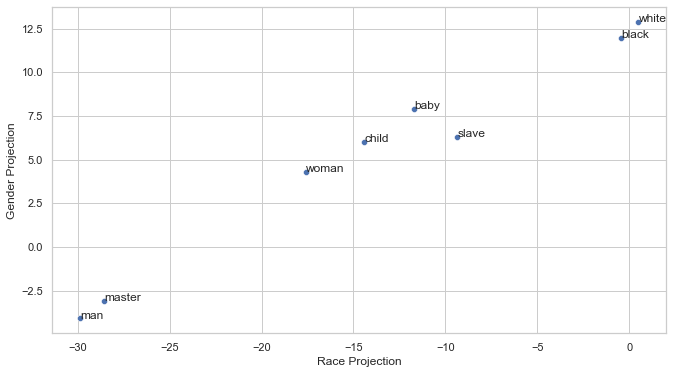

In [19]:
sns.set_theme()
sns.set(rc={'figure.figsize':(11,6)})
sns.set_style('whitegrid')
splot = sns.scatterplot(data=projections_df, x='race_proj', y='gender_proj')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(projections_df['race_proj'], projections_df['gender_proj'], projections_df.index.to_series(), plt.gca())

# Set x-axis label
plt.xlabel('Race Projection')
# Set y-axis label
plt.ylabel('Gender Projection')